In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
real_jets = np.load('/home/lukedeo/scratch/data/gan/jetimages.npy', mmap_mode='r')
ix = range(real_jets.shape[0])
np.random.shuffle(ix)
real_jets = np.array(real_jets[ix][:50000])

In [3]:
real_images = real_jets['image']
real_labels = real_jets['signal']

In [4]:
from acgan_jets_new import build_generator

Using TensorFlow backend.


In [5]:
g = build_generator(256)

In [6]:
# with open('/home/lukedeo/great-gan-256.json', 'w') as f:
#     f.write(g.to_json())

In [27]:
# fname = sorted(glob('params_generator*'))[-1]

In [93]:
fname = '/home/lukedeo/great-gan-256.h5'

In [94]:
g.load_weights(fname)

In [79]:
noise = np.random.normal(0, 1, (150000, 256))
sampled_labels = np.random.randint(0, 2, 150000)

In [95]:
# get a batch to display
generated_images = g.predict(
    [noise, sampled_labels.reshape(-1, 1, 1)], verbose=True, batch_size=128)

150000/150000 [==============================] - 64s    


In [96]:
generated_images = (generated_images) * 100

In [97]:
# transform (None, 1, 25, 25) => (None, 25, 25)
generated_images = np.squeeze(generated_images)

In [98]:
from matplotlib.colors import LogNorm

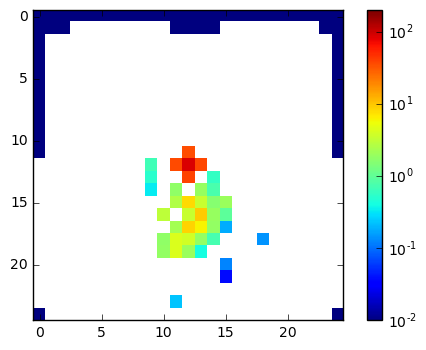

In [99]:
im = generated_images[23]
plt.imshow(im, interpolation='nearest', norm=LogNorm(vmin=1e-2, vmax=200))
plt.colorbar()

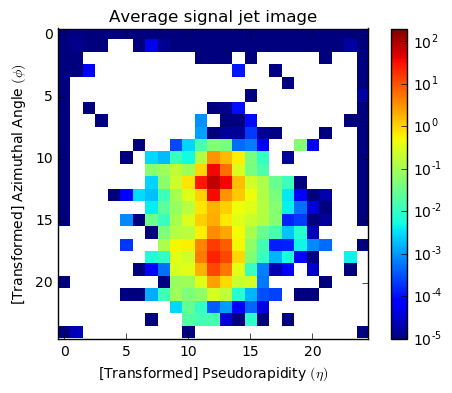

In [100]:
plt.imshow(generated_images[sampled_labels == 1].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average signal jet image')

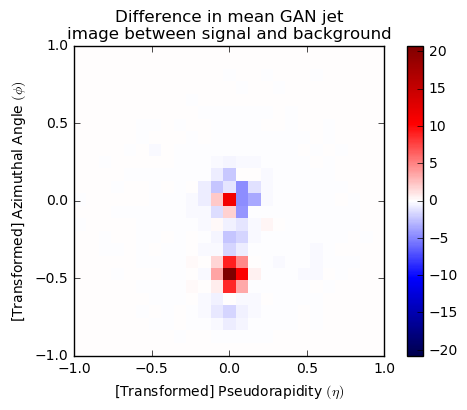

In [101]:
diff = generated_images[sampled_labels == 1].mean(axis=0) - generated_images[sampled_labels == 0].mean(axis=0)
lim = np.max(np.abs(diff))
plt.imshow(diff, interpolation='nearest', cmap=cm.seismic, vmax=lim, vmin=-lim, extent=[-1, 1, -1, 1])
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference in mean GAN jet\nimage between signal and background')
plt.colorbar()

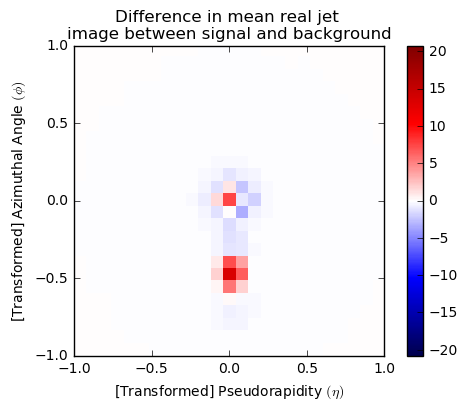

In [102]:
diff = real_images[real_labels == 1].mean(axis=0) - real_images[real_labels == 0].mean(axis=0)
plt.imshow(diff, interpolation='nearest', cmap=cm.seismic, vmax=lim, vmin=-lim, extent=[-1, 1, -1, 1])
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference in mean real jet \nimage between signal and background')
plt.colorbar()

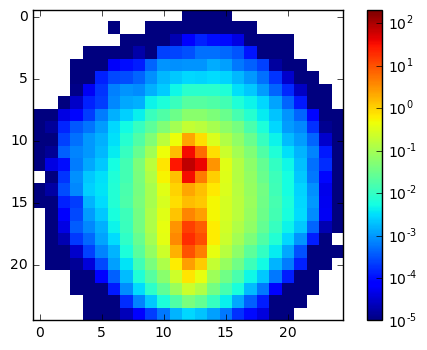

In [103]:
# plot the mean signal jet
plt.imshow(real_images[real_labels == 1].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()

In [89]:
# form the grids you need to represent the eta, phi coordinates
grid = 0.5 * (np.linspace(-1, 1, 26)[:-1] + np.linspace(-1, 1, 26)[1:])
eta = np.tile(grid, (25, 1))
phi = np.tile(grid[::-1].reshape(-1, 1), (1, 25))

In [90]:
def discrete_mass(jet_image):
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1, 2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1, 2))

    PT2 = np.square(Px) + np.square(Py)
    M2 = np.square(E) - (PT2 + np.square(Pz))
    M = np.sqrt(M2)
    return M

def discrete_pt(jet_image):
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1, 2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1, 2))

    return np.sqrt(np.square(Px) + np.square(Py))

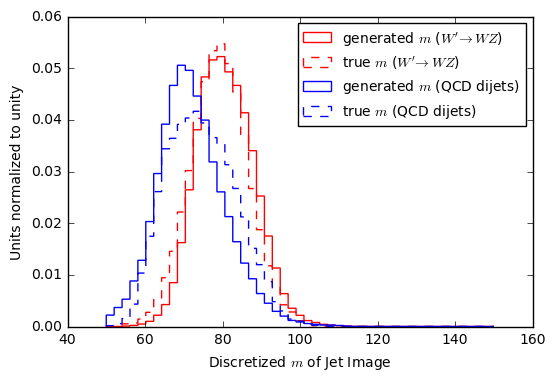

In [104]:
# plot the mass of the GAN vs the Pythia Jets
bins = np.linspace(50, 150, 50)
_ = plt.hist(discrete_mass(generated_images[sampled_labels == 1]), 
             bins=bins, histtype='step', label=r"generated $m$ ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(discrete_mass(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label=r"true $m$ ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(discrete_mass(generated_images[sampled_labels == 0]), 
             bins=bins, histtype='step', label=r'generated $m$ (QCD dijets)', normed=True, color='blue')
_ = plt.hist(discrete_mass(real_images[real_labels == 0]), 
             bins=bins, histtype='step', label=r'true $m$ (QCD dijets)', normed=True, color='blue', linestyle='dashed')

plt.xlabel(r'Discretized $m$ of Jet Image')
plt.ylabel(r'Units normalized to unity')
plt.legend(prop={'size':10})
plt.ylim(0, 0.06)
plt.show()

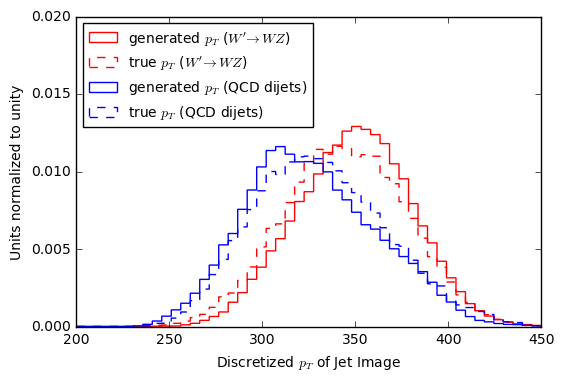

In [105]:
# plot the pT of the GAN vs the Pythia Jets
bins = np.linspace(200, 450, 50)
_ = plt.hist(discrete_pt(generated_images[sampled_labels == 1]), 
             bins=bins, histtype='step', label=r"generated $p_T$ ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(discrete_pt(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label=r"true $p_T$ ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(discrete_pt(generated_images[sampled_labels == 0]), 
             bins=bins, histtype='step', label=r'generated $p_T$ (QCD dijets)', normed=True, color='blue')
_ = plt.hist(discrete_pt(real_images[real_labels == 0]), 
             bins=bins, histtype='step', label=r'true $p_T$ (QCD dijets)', normed=True, color='blue', linestyle='dashed')
plt.xlabel(r'Discretized $p_T$ of Jet Image')
plt.ylabel(r'Units normalized to unity')
plt.legend(loc=2, prop={'size':10})
plt.ylim(0, 0.02)
plt.show()

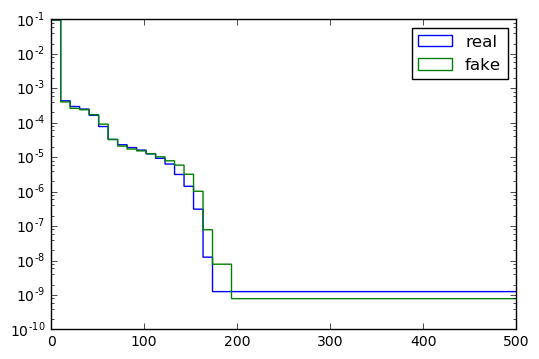

In [72]:
# _, bins, _ = plt.hist(real_images.ravel(), bins=np.logspace(-12, 3, 50), log=True, histtype='step', normed=True, label='real')
_, bins, _ = plt.hist(real_images.ravel(), bins=np.linspace(0, 500, 50), log=True, histtype='step', normed=True, label='real')
_ = plt.hist(generated_images.ravel(), bins=bins, log=True, histtype='step', normed=True, label='fake')
# plt.xscale('log')
plt.legend()

In [ ]:
real_images[0]

In [ ]:
np.save('/home/lukedeo/scratch/data/gan/slim.npy', real_jets)

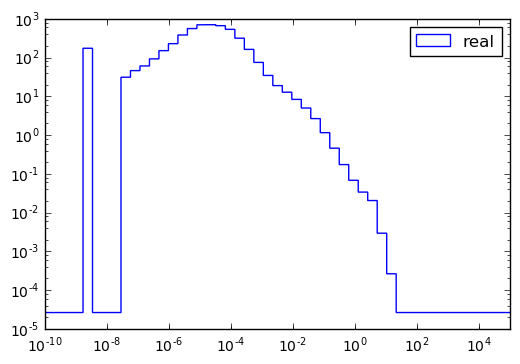

In [130]:
_, bins, _ = plt.hist(real_images.ravel() / 10, bins=np.logspace(-10, 5, 50), log=True, histtype='step', normed=True, label='real')
plt.xscale('log')
plt.legend()

In [121]:
np.log(real_images + 1e-10).max()

5.1207824

In [34]:
float((real_images.ravel() == 0).sum()) / len(real_images.ravel())

0.893187072

In [35]:
float((generated_images.ravel() == 0).sum()) / len(real_images.ravel())

0.932745184